## DATA SCIENCE NLP PROJECT ##
### Analysis of OKCupid Dating Profile Data ###

Hanqing YE | 
Spring 2024          

In [1]:
import numpy as np
import pandas as pd

import random

from matplotlib import pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans

import string
import re

import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, preprocess_string, stem_text
from gensim.models import LdaMulticore, Word2Vec
from gensim.models.coherencemodel import CoherenceModel

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

import spacy
from spacy.lang.en import English

import yake

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

[nltk_data] Downloading package punkt to /Users/hanqingye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hanqingye/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hanqingye/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


We have nearly 60,000 dating profiles from OKCupid, consisting of the following variables for each user:

In [2]:
#importing the dataset
okc_data = pd.read_csv('/Users/hanqingye/Desktop/data_science_NLP/data/okcupid_profiles.csv')
okc_data.head()
print(okc_data.columns)

Index(['age', 'status', 'sex', 'orientation', 'body_type', 'diet', 'drinks',
       'drugs', 'education', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'pets', 'religion', 'sign',
       'smokes', 'speaks', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4',
       'essay5', 'essay6', 'essay7', 'essay8', 'essay9'],
      dtype='object')


## Descriptive Statistics ##

In [3]:
# Key demographic attributes: age, sex, orientation, education, income

variables_of_interest = ['age', 'sex', 'orientation', 'education', 'income']
descriptive_stats = okc_data[variables_of_interest].describe(include='all')
print(descriptive_stats)

                 age    sex orientation                          education  \
count   59946.000000  59946       59946                              53318   
unique           NaN      2           3                                 32   
top              NaN      m    straight  graduated from college/university   
freq             NaN  35829       51606                              23959   
mean       32.340290    NaN         NaN                                NaN   
std         9.452779    NaN         NaN                                NaN   
min        18.000000    NaN         NaN                                NaN   
25%        26.000000    NaN         NaN                                NaN   
50%        30.000000    NaN         NaN                                NaN   
75%        37.000000    NaN         NaN                                NaN   
max       110.000000    NaN         NaN                                NaN   

                income  
count     59946.000000  
unique       

As we can see, men represent a higher share of the user profiles than women in our dataset; Straight users represent the majority of the dating profiles in our dataset; Around half of our users have graduated from college/university; Many users do not report their income.

Let's look at each of these variables in more detail through visualization.

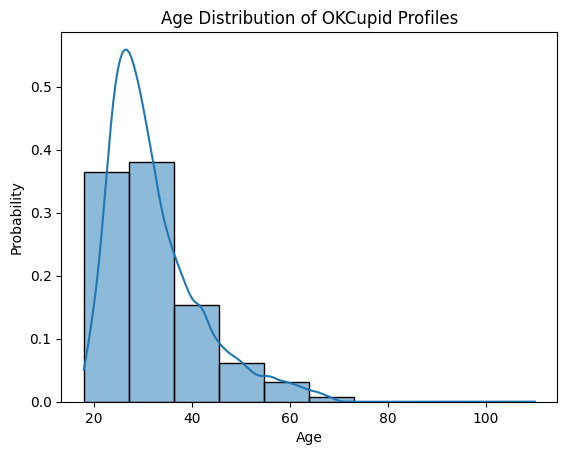

In [4]:
# Age
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.histplot(okc_data['age'], bins=10, kde=True, stat="probability")
plt.title('Age Distribution of OKCupid Profiles')
plt.xlabel('Age')
plt.ylabel('Probability')
plt.show()

# We can see that age 20-35 represent nearly 80% of the profiles in our dataset


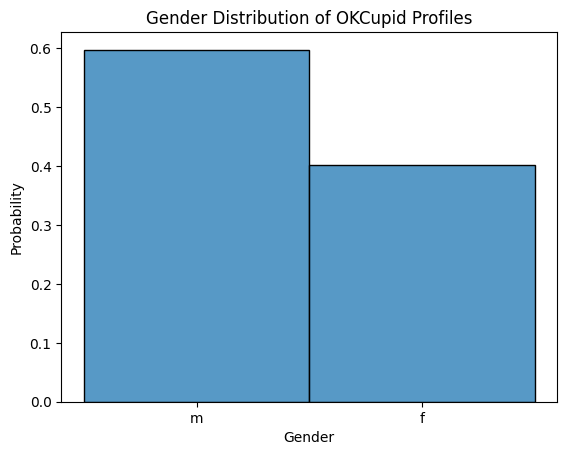

In [5]:
# sex

sns.histplot(okc_data['sex'], kde=False, stat="probability")
plt.title('Gender Distribution of OKCupid Profiles')
plt.xlabel('Gender')
plt.ylabel('Probability')
plt.show()

# Men represent 60% of the user profiles in our dataset and women around 40%.

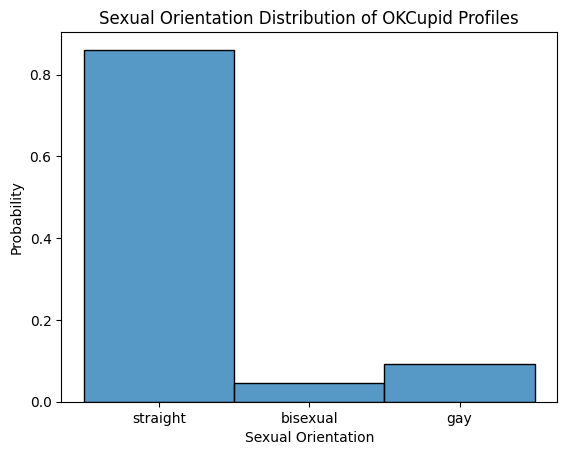

In [6]:
# Orientation 

sns.histplot(okc_data['orientation'], stat="probability")
plt.title('Sexual Orientation Distribution of OKCupid Profiles')
plt.xlabel('Sexual Orientation')
plt.ylabel('Probability')
plt.show()

# Straight users represent nearly 90% of user profiles, bisexual around 5%, and gay around 10%. We are unbalanced on non-straighter users.

In [7]:
# Education
print(okc_data['education'].unique())

['working on college/university' 'working on space camp'
 'graduated from masters program' 'graduated from college/university'
 'working on two-year college' nan 'graduated from high school'
 'working on masters program' 'graduated from space camp'
 'college/university' 'dropped out of space camp'
 'graduated from ph.d program' 'graduated from law school'
 'working on ph.d program' 'two-year college'
 'graduated from two-year college' 'working on med school'
 'dropped out of college/university' 'space camp'
 'graduated from med school' 'dropped out of high school'
 'working on high school' 'masters program' 'dropped out of ph.d program'
 'dropped out of two-year college' 'dropped out of med school'
 'high school' 'working on law school' 'law school'
 'dropped out of masters program' 'ph.d program'
 'dropped out of law school' 'med school']


In [8]:
from pandas.api.types import CategoricalDtype

# Group education into fewer categories
def categorize_education(row):
    if row['education'] == "dropped out of high school" or row['education'] == 'working on high school':
        return "some high school"
    elif row['education'] == "graduated from high school" or row['education'] == 'high school':
        return "high school"
    elif row['education'] == 'working on two-year college' or row['education'] == 'dropped out of two-year college':
        return "some two-year college"
    elif row['education'] == 'graduated from two-year college' or row['education'] == 'two-year college':
        return "two-year college"
    elif row['education'] == 'working on college/university' or row['education'] == 'dropped out of college/university':
        return "some college/university"
    elif row['education'] == 'graduated from college/university' or row['education'] == 'college/university':
        return "college/university"
    elif row['education'] == 'working on masters program' or row['education'] == 'dropped out of masters program' or row['education'] == 'working on law school' or row['education'] == 'dropped out of law school':
        return "some masters"
    elif row['education'] == 'graduated from masters program' or row['education'] == 'masters program' or row['education'] == 'graduated from law school' or row['education'] == 'law school':
        return "masters"
    elif row['education'] == 'working on ph.d program' or row['education'] == 'dropped out of ph.d program' or row['education'] == 'working on med school' or row['education'] == 'dropped out of med school':
        return "some phd/md"
    elif row['education'] == 'ph.d program' or row['education'] == 'graduated from ph.d program' or row['education'] == 'graduated from med school' or row['education'] == 'med school':
        return "phd/md"
    else:
        return "other"

# Apply the function to create the education category column
okc_data['education_cat'] = okc_data.apply(categorize_education, axis=1)

# Create a numerical ordered column for education level
education_mapping = {
    "other": 1,
    "some high school": 2,
    "high school": 3,
    "some two-year college": 4,
    "two-year college": 5,
    "some college/university": 6,
    "college/university": 7,
    "some masters": 8,
    "masters": 9,
    "some phd/md": 10,
    "phd/md": 11
}

# Map the textual categories to their corresponding numerical values
okc_data['education_level'] = okc_data['education_cat'].map(education_mapping)

# Make education_level an ordered variable
education_order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 
education_cat_type = CategoricalDtype(categories=education_order, ordered=True)
okc_data['education_level'] = okc_data['education_level'].astype(education_cat_type)

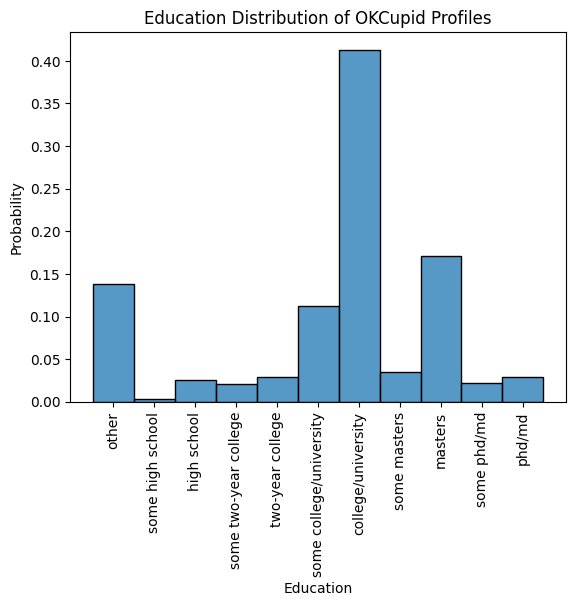

In [9]:
# Education

# Sort okc_data based on 'education_level'
okc_data_sorted = okc_data.sort_values('education_level')

sns.histplot(data=okc_data_sorted, x='education_cat', stat="probability", discrete=True)
plt.title('Education Distribution of OKCupid Profiles')
plt.xlabel('Education')
plt.ylabel('Probability')
plt.xticks(rotation=90)
plt.show()

We can see that most users in our dataset are college/university graduates (around 40%) or have a master's degree (around 17%). In general, our dataset is more unbalanced on users with lower levels of education. The "other" category represents users who answered "working on/dropped out from/graduated from space camp". This doesn't refer to an actual educational institution or level in the traditional sense. It's likely used humorously or whimsically by users to indicate something about their personality, interests, or as a playful way to engage with/avoid the question about their education.

## Textual Analysis ##

Most of the textual data in OKCupid dating profiles exist in the "essay0" to "essay9", where users are free to write answers 
to any of the following questions:

- About Me / Self summary

- Current Goals / Aspirations

- My Golden Rule / My traits

- I could probably beat you at / Talent

- The last show I binged / Hobbies

- A perfect day / Moments

- I value / Needs

- The most private thing I'm willing to admit / Secrets

- What I'm actually looking for / Dating


We will extract the essay data and aggregate them for each user.

In [10]:
#creating the essay subset
essays = okc_data[['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9']]
essays.head()

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


### Text Preprocessing ###

In [11]:
essays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   essay0  54458 non-null  object
 1   essay1  52374 non-null  object
 2   essay2  50308 non-null  object
 3   essay3  48470 non-null  object
 4   essay4  49409 non-null  object
 5   essay5  49096 non-null  object
 6   essay6  46175 non-null  object
 7   essay7  47495 non-null  object
 8   essay8  40721 non-null  object
 9   essay9  47343 non-null  object
dtypes: object(10)
memory usage: 4.6+ MB


In [12]:
# Fill missing values with "." which we can remove later in preprocessing
essays = essays.fillna('.')
essays.head()

,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,.,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,.,.,i am very open and will share just about anyth...,.
2,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,.,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",.,cats and german philosophy,.,.,you feel so inclined.
4,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",.,.,.,.,.


In [13]:
#aggregating user-generated essays for each user
texts = []
for i in range(59946):
    texts.append(''.join(essays.loc[i]))
essays['texts'] = texts
essays.texts.head()

0    about me:  i would love to think that i was so...
1    i am a chef: this is what that means. 1. i am ...
2    i'm not ashamed of much, but writing public te...
3    i work in a library and go to school. . .readi...
4    hey how's it going? currently vague on the pro...
Name: texts, dtype: object

In [271]:
# Calculate the median number of essay columns filled out for each row (excluding '.')
filled_columns = essays.iloc[:, :10].apply(lambda row: (row != '.').sum(), axis=1)
median_filled = filled_columns.median()
percentile25_filled = filled_columns.quantile(0.25)
percentile75_filled = filled_columns.quantile(0.75)
print(f"The number of essays columns filled out is: 25% {percentile25_filled} median: {median_filled} 75% {percentile75_filled}")

The number of essays columns filled out is: 25% 7.0 median: 9.0 75% 10.0


In [272]:
# Calculate the median word count
word_count = essays['texts'].str.split().apply(len)
median_word_count = word_count.median()
percentile25_word_count = word_count.quantile(0.25)
percentile75_word_count = word_count.quantile(0.75)

print(f"The length of essays, in terms of number of words, is: 25% {percentile25_word_count} median: {median_word_count} 75% {percentile75_word_count}")

The length of essays, in terms of number of words, is: 25% 152.0 median: 291.0 75% 473.0


Now we tokenize, remove stop words and punctuations, and lemmatize using the python function we wrote and separately saved: process_chunk.

Due to the number of rows of data (nearly 60,000) and the large amount of time it takes to preprocess, we split the corpus into chunks, parallel process the chunks, and use nlp.pipe to batch process within each chunk.

(Parallel processing took us 11 minutes, compared to 21 minutes without parallel processing.)

In [7]:
%%script false

from concurrent.futures import ProcessPoolExecutor
from preprocess import process_chunk  

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def main(essays_texts):
    # Calculate number of chunks and prepare them
    num_chunks = 10
    chunks = list(chunker(essays_texts, len(essays_texts) // num_chunks))
    
    # Parallel processing
    with ProcessPoolExecutor() as executor:
        processed_chunks = list(executor.map(process_chunk, chunks))
        
    # Flatten the list of processed chunks inside main and return
    processed_texts = [doc for chunk in processed_chunks for doc in chunk]
    return processed_texts

if __name__ == "__main__":
    essays_texts = essays['texts'].tolist()  # Convert DataFrame column to list
    processed_texts = main(essays_texts)  # Call main function with the texts
    essays['lems'] = processed_texts  # Assign the processed texts back to DataFrame

# Save the data frame so next time we won't have to run it again
essays.to_csv('~/Desktop/data_science_NLP/data/essays.csv', index=False)

In [16]:
# Due to matching computational intensity, we take a sample of 3000 profiles for later steps
# (we use the same sample of profiles for other matching methods later to compare and evaluate)

essays = pd.read_csv('/Users/hanqingye/Desktop/data_science_NLP/data/essays.csv')
okc_data['texts'] = essays['texts']
okc_data['lems'] = essays['lems']

sample = okc_data.sample(n=3000, replace=False, random_state=3948) # setting random seed for reproducibility
sample['id'] = sample.index

# Convert String Representations of lemmatized profiles back to Lists
import ast
sample['lems'] = sample['lems'].apply(ast.literal_eval)

# Reset sample index
sample.reset_index(drop=True, inplace=True)

In [17]:
sample.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay5,essay6,essay7,essay8,essay9,education_cat,education_level,texts,lems,id
0,29,single,m,gay,athletic,mostly anything,socially,never,working on masters program,white,...,reading iphone and ipod macbook pro good peopl...,my future! my next vacation/weekend getaway fr...,usually at home lounging while watching movies...,i hate gyms with a passion.,you're actually seeking a date or something mo...,some masters,8,"i'm a nice, energetic, happy go lucky guy. i l...","[nice, energetic, happy, lucky, guy, laugh, lo...",18954
1,27,single,m,straight,athletic,anything,socially,never,graduated from college/university,other,...,NaN,NaN,with friends... either going out or vegging out,NaN,NaN,college/university,7,.i'm back in school pursuing an mba after 4 ye...,"[school, pursue, mba, year, work, fountainhead...",26866
2,31,single,f,straight,curvy,mostly anything,socially,NaN,college/university,asian,...,NaN,NaN,NaN,NaN,you're in san francisco or near menlo park.,college/university,7,"i'm sweet, cute, into food and wine.i work in ...","[sweet, cute, food, work, menlo, park, love, j...",21490
3,39,married,f,bisexual,jacked,mostly anything,rarely,never,graduated from college/university,asian,...,guess you'll never know unless you ask right?,guess you'll never know unless you ask right?,guess you'll never know unless you ask right?,guess you'll never know unless you ask right?,NaN,college/university,7,if you want to get to know me than ask me a qu...,"[want, know, ask, question, oh, yes, ask, marr...",30550
4,61,single,f,straight,fit,anything,socially,NaN,graduated from masters program,white,...,NaN,NaN,i always make plans for the weekend whether it...,NaN,please send me a message if you want to meet a...,masters,9,"i am up for adventure, easy to be with, fun, c...","[adventure, easy, fun, caring, busy, art, clas...",2842


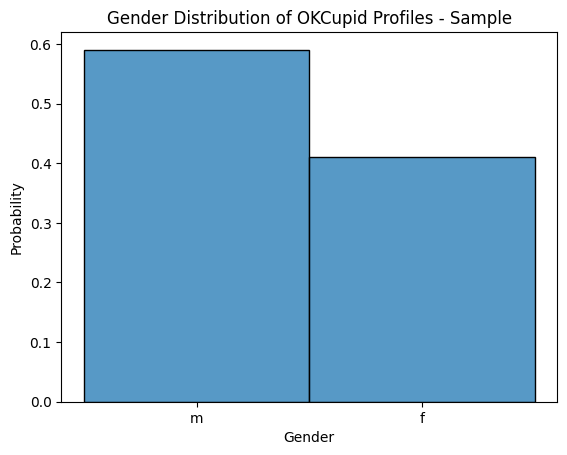

In [182]:
# sex

sns.histplot(sample['sex'], kde=False, stat="probability")
plt.title('Gender Distribution of OKCupid Profiles - Sample')
plt.xlabel('Gender')
plt.ylabel('Probability')
plt.show()

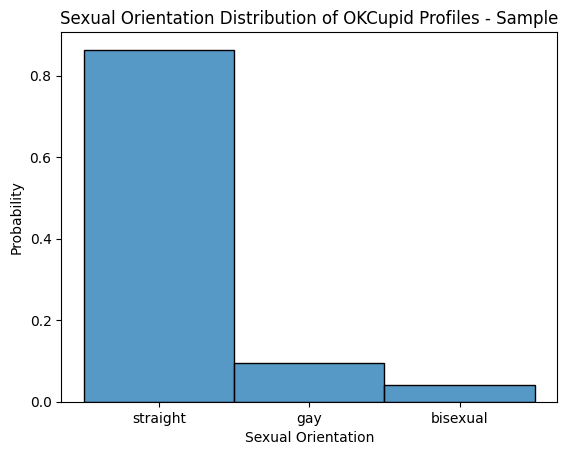

In [187]:
# Orientation 

orientation_order = ["straight", "gay", "bisexual"] 
sample['orientation'] = pd.Categorical(sample['orientation'], categories=orientation_order, ordered=True)

sns.histplot(sample['orientation'], stat="probability")
plt.title('Sexual Orientation Distribution of OKCupid Profiles - Sample')
plt.xlabel('Sexual Orientation')
plt.ylabel('Probability')
plt.xticks(rotation=0)  # Optional: rotate x-axis labels for better readability if needed
plt.show()

### Interesting possible directions to pursue: 
1. Sentiment Analysis |
Objective: Determin motional tone behind a series of words used in the profiles to help understand the sentiment of the profile owner, categorizing it as positive, negative, or neutral. 
2. Similarity Analysis |
Objective: Find and match profiles that are similar in content and preferences, aiding in recommendation systems.
Method: Use cosine similarity or other distance measures on vector representations of profiles obtained through methods like TF-IDF or word embeddings (Word2Vec, GloVe).
3. Demographic Prediction |
Objective: Predict demographic information (e.g., age, gender, education) based on the profile text.
Method: Train classification models on profiles with known demographic attributes to predict the demographics of other users.

I will do profile similarity analysis for this project.

## 2. Similarity Analysis

### Step 1: Pre-filter Matches with Hard Criteria (Sexual Orientation Compatibility) ###

In [18]:
# Sex orientation compatibility function - Hard criteria

def sex_orientation_compatibility(user1_sex, user1_orientation, user2_sex, user2_orientation):
    # Straight male and female match
    if user1_sex == 'm' and user1_orientation == 'straight' and user2_sex == 'f':
        return 1
    elif user1_sex == 'f' and user1_orientation == 'straight' and user2_sex == 'm':
        return 1
    # Bisexual user matches with anyone
    elif user1_orientation == 'bisexual':
        return 1
    elif user2_orientation == 'bisexual':
        return 1
    # Gay male and male match
    elif user1_sex == 'm' and user1_orientation == 'gay' and user2_sex == 'm' and user2_orientation == 'gay':
        return 1
    # Gay female and female match
    elif user1_sex == 'f' and user1_orientation == 'gay' and user2_sex == 'f' and user2_orientation == 'gay':
        return 1
    # All other cases 
    else:
        return 0

In [19]:
# Split the dataset into subgroups
straight_males = sample[(sample['sex'] == 'm') & (sample['orientation'] == 'straight')]
straight_females = sample[(sample['sex'] == 'f') & (sample['orientation'] == 'straight')]
gay_males = sample[(sample['sex'] == 'm') & (sample['orientation'] == 'gay')]
gay_females = sample[(sample['sex'] == 'f') & (sample['orientation'] == 'gay')]
bisexual_males = sample[(sample['sex'] == 'm') & (sample['orientation'] == 'bisexual')]
bisexual_females = sample[(sample['sex'] == 'f') & (sample['orientation'] == 'bisexual')]

In [20]:
import itertools

# Initialize an empty list to hold compatible pairs
compatible_pairs = []

# Straight male-female compatibility
for idx1, user1 in straight_males.iterrows():
    for idx2, user2 in straight_females.iterrows():
        compatible_pairs.append((user1['id'], user2['id']))

# Gay male compatibility
for user1, user2 in itertools.combinations(gay_males.iterrows(), 2):
    compatible_pairs.append((user1[1]['id'], user2[1]['id']))

# Gay female compatibility
for user1, user2 in itertools.combinations(gay_females.iterrows(), 2):
    compatible_pairs.append((user1[1]['id'], user2[1]['id']))

# Bisexual male compatibility (anyone but gay females)
for idx1, user1 in bisexual_males.iterrows():
    for idx2, user2 in pd.concat([straight_males, straight_females, bisexual_females, gay_males]).iterrows():
            compatible_pairs.append((user1['id'], user2['id']))

for user1, user2 in itertools.combinations(bisexual_males.iterrows(), 2):
    compatible_pairs.append((user1[1]['id'], user2[1]['id']))

# Bisexual female compatibility (anyone but gay males)
for idx1, user1 in bisexual_females.iterrows():
    for idx2, user2 in pd.concat([straight_males, straight_females, bisexual_males, gay_females]).iterrows():
            compatible_pairs.append((user1['id'], user2['id']))

for user1, user2 in itertools.combinations(bisexual_females.iterrows(), 2):
    compatible_pairs.append((user1[1]['id'], user2[1]['id']))
    
# Convert the list of compatible pairs to a DataFrame for further processing
compatible_pairs_df = pd.DataFrame(compatible_pairs, columns=['user1_id', 'user2_id'])

# Now we can proceed with profile similarity calculations and other compatibility metrics for the pairs in compatible_pairs_df

In [21]:
print("Number of user 1:", len(compatible_pairs_df['user1_id'].unique()))
print("Number of user 2:",len(compatible_pairs_df['user2_id'].unique()))

Number of user 1: 1949
Number of user 2: 3000


In [188]:
len(compatible_pairs_df)

1991982

### Step 2: Profile similarity based on textual analysis

#### 2.1.a.   LDA model ####

We'll do dimension reduction of user essays using LDA first, then compare profile similarity using different distance measures.

Step 1: Preprocessing of essay data (done)

Step 2: Create a document term matrix

Step 3: Apply LDA (each document can now be represented as a distribution over the topics)

Step 4: Calculate document similarity

In [232]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Create a Gensim Dictionary
sample_dict = Dictionary(sample['lems'])

# Filter out extremes to limit the number of features
sample_dict.filter_extremes(no_below=25, no_above=0.8, keep_n=50000)

# Convert documents to vectors
sample_corpus = [sample_dict.doc2bow(doc) for doc in sample['lems']]

# Apply LDA
lda_model = LdaModel(corpus=sample_corpus, id2word=sample_dict, num_topics=25, passes=3)

# Use LDA model to get topic distributions for documents
# sample_topics = [lda_model.get_document_topics(bow) for bow in sample_corpus]

In [23]:
for index,topic in lda_model.print_topics(-1):
    print("Topic: {} \nIdeas: {}".format(index, topic))
    print("\n")

Topic: 0 
Ideas: 0.008*"like" + 0.007*"music" + 0.007*"love" + 0.007*"work" + 0.007*"food" + 0.006*"people" + 0.006*"friend" + 0.006*"movie" + 0.005*"life" + 0.005*"time"


Topic: 1 
Ideas: 0.204*"profile" + 0.181*"want" + 0.074*"word" + 0.018*"book" + 0.014*"love" + 0.013*"like" + 0.011*"smoking" + 0.010*"movie" + 0.010*"v" + 0.010*"eat"


Topic: 2 
Ideas: 0.037*"like" + 0.022*"work" + 0.021*"friend" + 0.020*"life" + 0.015*"passion" + 0.013*"person" + 0.013*"full" + 0.013*"family" + 0.013*"organization" + 0.012*"good"


Topic: 3 
Ideas: 0.016*"like" + 0.015*"love" + 0.013*"world" + 0.013*"want" + 0.013*"find" + 0.010*"music" + 0.009*"random" + 0.009*"video" + 0.008*"outside" + 0.008*"heart"


Topic: 4 
Ideas: 0.069*"love" + 0.029*"friend" + 0.027*"family" + 0.025*"m" + 0.016*"movie" + 0.015*"go" + 0.012*"work" + 0.012*"music" + 0.012*"child" + 0.012*"travel"


Topic: 5 
Ideas: 0.241*"fuck" + 0.075*"shit" + 0.043*"harvey" + 0.021*"black" + 0.020*"swan" + 0.018*"sauce" + 0.014*"kill" + 

As we can see, these topics are not very coherent. Let's experiment with different numbers of topics and see if we can increase the coherence. We use parallel computing to speed up the process (for the whole essay corpus, it took 55 minutes to train 8 LDA models using parallel processing, for 3000 profiles, the training time is significantly less).

In [94]:
from coherence_utils import compute_coherence_for_one

import concurrent.futures

# Parallel computing calling the compute_coherence_for_one function
def parallel_compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    futures = []
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        for num_topics in range(start, limit, step):
            future = executor.submit(compute_coherence_for_one, dictionary, corpus, texts, num_topics)
            futures.append(future)
        
        for future in concurrent.futures.as_completed(futures):
            model, coherence, num_topics = future.result()
            model_list.append((num_topics, model))
            coherence_values.append((num_topics, coherence))
    
    # Sort lists by num_topics
    model_list.sort(key=lambda x: x[0])
    coherence_values.sort(key=lambda x: x[0])
    
    # Just return models and coherences in order, stripping away num_topics
    return [model for _, model in model_list], [coherence for _, coherence in coherence_values]

# Run it over 50-120 topics with increment 10
model_list, coherence_values = parallel_compute_coherence(sample_dict, sample_corpus, sample['lems'], limit=100, start=25, step=5)


In [114]:
coherence_values

[0.3308350505643445,
 0.33046469753639934,
 0.32162798669118414,
 0.3268098749191656,
 0.316082557137133,
 0.3191221946147739,
 0.3019284959102509,
 0.3015348254987494,
 0.2996660062688545,
 0.3054250909297621,
 0.2994794394516244,
 0.30047871923026537,
 0.29739118610556864,
 0.2974507429504767,
 0.2979284805960729]

In [95]:
# Find the number of topics with the highest coherence score
max_coherence_val = max(coherence_values)
optimal_LdaModel_index = coherence_values.index(max_coherence_val)
optimal_LdaModel = model_list[optimal_LdaModel_index]
optimal_num_topics = range(25, 81, 5)[optimal_LdaModel_index]

print("Optimal number of topics:", optimal_num_topics)
print("Highest coherence value:", max_coherence_val)


Optimal number of topics: 25
Highest coherence value: 0.3308350505643445


In [97]:
for index, topic in optimal_LdaModel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(index, topic))
    print("\n")

Topic: 0 
Words: 0.023*"love" + 0.021*"like" + 0.018*"woman" + 0.016*"look" + 0.014*"meet" + 0.014*"want" + 0.013*"life" + 0.012*"good" + 0.009*"enjoy" + 0.009*"know"


Topic: 1 
Words: 0.048*"tip" + 0.037*"pork" + 0.021*"bored" + 0.014*"spare" + 0.013*"short" + 0.011*"bacon" + 0.011*"d" + 0.009*"steak" + 0.009*"sit" + 0.009*"shoulder"


Topic: 2 
Words: 0.014*"time" + 0.013*"good" + 0.013*"work" + 0.011*"like" + 0.011*"love" + 0.010*"life" + 0.010*"think" + 0.010*"people" + 0.008*"know" + 0.008*"want"


Topic: 3 
Words: 0.027*"love" + 0.018*"friend" + 0.018*"good" + 0.014*"life" + 0.014*"like" + 0.013*"thing" + 0.012*"people" + 0.011*"work" + 0.011*"time" + 0.010*"music"


Topic: 4 
Words: 0.013*"run" + 0.011*"work" + 0.009*"hiking" + 0.008*"friend" + 0.008*"love" + 0.007*"trip" + 0.006*"time" + 0.006*"like" + 0.006*"hard" + 0.006*"year"


Topic: 5 
Words: 0.018*"like" + 0.016*"love" + 0.011*"music" + 0.011*"good" + 0.011*"thing" + 0.008*"new" + 0.008*"people" + 0.007*"food" + 0.006*"

We'll stick to the LDA model that maximized the coherence score across all the numbers of topics we have tried.

In [165]:
# Visualizing the topics
lda_vis = pyLDAvis.gensim.prepare(optimal_LdaModel, corpus = sample_corpus, dictionary=sample_dict, mds='mmds')
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.068656 -0.014654       1        1  18.261047
5     -0.018298 -0.002076       2        1  14.716306
2      0.015092  0.007446       3        1  13.936761
6      0.019132 -0.035542       4        1  13.057385
12     0.027715  0.001572       5        1  12.695541
7     -0.010576 -0.046601       6        1   8.985583
13     0.182014 -0.061726       7        1   3.136019
23    -0.092761 -0.060578       8        1   2.646454
18    -0.004889 -0.087602       9        1   2.481928
15     0.100285 -0.066717      10        1   2.362976
10     0.161350  0.020738      11        1   2.319585
14     0.072188  0.043167      12        1   2.058058
21    -0.015563 -0.137490      13        1   1.368641
11    -0.089149 -0.108709      14        1   0.726476
0      0.079487 -0.151337      15        1   0.409692
22    -0.199371 -0.000688      16        1   0.226811
17     0.089368  0.078450      17        1   0.216974
8      0.042131  0.131048      18        1   0.082218
16    -0.100104  0.022228      19        1   0.063723
4     -0.020346  0.083315      20        1   0.060029
1     -0.090879  0.148932      21        1   0.054697
24    -0.038534  0.051754      22        1   0.038602
9     -0.060326  0.059063      23        1   0.033518
19    -0.074166  0.083710      24        1   0.032952
20    -0.042453  0.042296      25        1   0.028023, topic_info=       Term         Freq        Total Category  logprob  loglift
59     love  6641.000000  6641.000000  Default  30.0000  30.0000
56     like  7091.000000  7091.000000  Default  29.0000  29.0000
139    want  2612.000000  2612.000000  Default  28.0000  28.0000
29   friend  4476.000000  4476.000000  Default  27.0000  27.0000
34     good  5231.000000  5231.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
58      lot     0.261543  1851.534405  Topic25  -6.0770  -0.6850
55     life     0.293537  3581.858862  Topic25  -5.9616  -1.2295
67      new     0.260751  2816.354149  Topic25  -6.0800  -1.1075
101   watch     0.238845  1553.362667  Topic25  -6.1678  -0.6002
133    know     0.241000  2695.129078  Topic25  -6.1588  -1.1422

[1705 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1843      1  0.032440  academic
1843      2  0.227078  academic
1843      3  0.064879  academic
1843      4  0.064879  academic
1843      5  0.259517  academic
...     ...       ...       ...
1865      4  0.528712   youtube
1865      5  0.201414   youtube
1865      8  0.025177   youtube
1865      9  0.025177   youtube
1865     10  0.025177   youtube

[9997 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 7, 13, 8, 14, 24, 19, 16, 11, 15, 22, 12, 1, 23, 18, 9, 17, 5, 2, 25, 10, 20, 21])

In [102]:
# Save the visualization as an HTML file
pyLDAvis.save_html(lda_vis, '/Users/hanqingye/Desktop/data_science_NLP/graphs/lda_vis.html')

#### Keywords extraction

As we can see, the coherence of using lemmatized text from our sample of user essays isn't very high. What if instead of using the whole lemmatized text, we use keywords extracted from each user essay and run LDA over these keywords to compare profile similarity? Would keywords improve our LDA model's coherence?

In [103]:
#Extracted keyword strings
sample['lems_str'] = sample['lems'].apply(lambda x: ' '.join(x))
yake_keyword_extractor = yake.KeywordExtractor(lan='en', n=1, dedupLim=0.7, top=5, dedupFunc='seqm', windowsSize=1)

keywords = sample['lems_str'].apply(lambda x: yake_keyword_extractor.extract_keywords(x))
keywords_clean = keywords.apply(lambda i: list(dict(i).keys()))

keywords_str = keywords_clean.apply(lambda x: ' '.join(x))

keywords_str[0:10]

0             time people care work school
1             school vegge pursue mba year
2               menlo park sweet work cute
3       question marry bother contact good
4           fun adventure plan travel easy
5            friend game life people music
6            mouth thing talk respect open
7    year date sweet preferably indigenous
8             read work friend enjoy place
9              friend fun hang easy loving
Name: lems_str, dtype: object

In [104]:
# Create a Gensim Corpus and Dictionary
keywords_corpus = keywords_str.apply(lambda x: word_tokenize(x))
keywords_dict = corpora.Dictionary(keywords_corpus)

# Create a Bag of Words Representation
keywords_bow = [keywords_dict.doc2bow(doc) for doc in keywords_corpus]

In [82]:
# Run the parallel computing coherence function over 50-120 topics with increment 10
keywords_model_list, keywords_coherence_values = parallel_compute_coherence(keywords_dict, corpus=keywords_bow, texts=keywords_corpus, limit=100, start=25, step=5)

In [105]:
keywords_coherence_values

[0.3924246921207088,
 0.40825416654793373,
 0.42580406539389165,
 0.4437765188085431,
 0.45366313262964647,
 0.4672188243966825,
 0.45587955398868996,
 0.46983248847643944,
 0.4677472454997052,
 0.4732586149892339,
 0.46587303922419665,
 0.47721205232266667,
 0.4743655332363814,
 0.580962819270867,
 0.6621803315016227]

In [106]:
# Find the number of topics with the highest coherence score
max_keywords_coherence_val = max(keywords_coherence_values)
optimal_keywords_LdaModel_index = keywords_coherence_values.index(max_keywords_coherence_val)
optimal_keywords_LdaModel = keywords_model_list[optimal_keywords_LdaModel_index]
optimal_keywords_num_topics = range(25, 100, 5)[optimal_keywords_LdaModel_index]

print("Optimal number of keyword topics:", optimal_keywords_num_topics)
print("Highest keywords coherence value:", max_keywords_coherence_val)

Optimal number of keyword topics: 95
Highest keywords coherence value: 0.6621803315016227


In [110]:
for index, topic in optimal_keywords_LdaModel.print_topics(-1):
    print("Topic: {} \nWords: {}".format(index, topic))
    print("\n")

Topic: 0 
Words: 0.182*"people" + 0.181*"love" + 0.140*"world" + 0.107*"good" + 0.090*"talk" + 0.068*"time" + 0.064*"music" + 0.057*"work" + 0.032*"friend" + 0.014*"enjoy"


Topic: 1 
Words: 0.000*"suppose" + 0.000*"dork" + 0.000*"beauty" + 0.000*"wisdom" + 0.000*"obvious" + 0.000*"recording" + 0.000*"logic" + 0.000*"austin" + 0.000*"vancouver" + 0.000*"count"


Topic: 2 
Words: 0.000*"suppose" + 0.000*"dork" + 0.000*"beauty" + 0.000*"wisdom" + 0.000*"obvious" + 0.000*"recording" + 0.000*"logic" + 0.000*"austin" + 0.000*"vancouver" + 0.000*"count"


Topic: 3 
Words: 0.530*"read" + 0.153*"stuff" + 0.108*"good" + 0.048*"time" + 0.026*"feel" + 0.000*"dork" + 0.000*"vancouver" + 0.000*"recording" + 0.000*"logic" + 0.000*"suppose"


Topic: 4 
Words: 0.226*"wan" + 0.226*"na" + 0.053*"oakland" + 0.011*"makinq" + 0.004*"people" + 0.001*"work" + 0.000*"fitness" + 0.000*"logic" + 0.000*"suppose" + 0.000*"dork"


Topic: 5 
Words: 0.283*"conversation" + 0.030*"begin" + 0.016*"clue" + 0.002*"stuff"

In [113]:
# Visualizing the topics
keywords_vis = pyLDAvis.gensim.prepare(optimal_keywords_LdaModel, corpus = keywords_bow, dictionary=keywords_dict, mds='mmds')
keywords_vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
74     0.232372 -0.469199       1        1  6.480584
75     0.114931 -0.476020       2        1  4.817347
36     0.403409 -0.322643       3        1  4.492508
73    -0.254562 -0.442393       4        1  3.718525
43     0.438317 -0.199085       5        1  3.358774
...         ...       ...     ...      ...       ...
56    -0.057753  0.105187      91        1  0.295114
57    -0.057753  0.105187      92        1  0.295114
58    -0.057753  0.105187      93        1  0.295114
24    -0.057753  0.105187      94        1  0.295114
59    -0.057744  0.105166      95        1  0.295114

[95 rows x 5 columns], topic_info=      Term         Freq        Total Category  logprob  loglift
45    love  1130.000000  1130.000000  Default  30.0000  30.0000
4     work   545.000000   545.000000  Default  29.0000  29.0000
25    life   409.000000   409.000000  Default  28.0000  28.0000
3     time   561.000000   561.000000  Default  27.0000  27.0000
31   thing   626.000000   626.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
21    plan     0.020308     7.086895  Topic95  -7.6481  -0.0294
23  friend     0.020308   685.931525  Topic95  -7.6481  -4.6020
24    game     0.020308   108.922834  Topic95  -7.6481  -2.7618
25    life     0.020308   409.681175  Topic95  -7.6481  -4.0866
26   music     0.020308   542.845768  Topic95  -7.6481  -4.3680

[4141 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
794      36  0.406015  activate
795      36  0.406015  actively
162      39  0.649909     anime
244      29  0.925346      area
133       2  0.054452       art
...     ...       ...       ...
284      24  0.823996   writing
181       9  0.962830      yeah
8         3  0.026960      year
8         6  0.037744      year
8        19  0.922034      year

[327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[75, 76, 37, 74, 44, 51, 84, 90, 92, 61, 29, 65, 78, 23, 55, 54, 1, 85, 15, 4, 66, 83, 48, 56, 11, 70, 95, 18, 22, 91, 10, 88, 43, 63, 46, 62, 28, 80, 53, 5, 6, 41, 8, 94, 93, 67, 68, 69, 3, 71, 72, 89, 73, 82, 12, 87, 86, 77, 9, 79, 14, 7, 81, 13, 24, 64, 16, 26, 27, 30, 31, 32, 33, 34, 35, 36, 21, 38, 39, 40, 42, 20, 45, 47, 2, 49, 50, 19, 52, 17, 57, 58, 59, 25, 60])

#### 2.1.b. Calculate LDA-based profile similarity ####

In [233]:
# Get the topic distribution of each profile
sample_topic_distributions = [optimal_LdaModel.get_document_topics(bow) for bow in sample_corpus]

# Sample topic distributions shows for each profile its probability over topics
sample_topic_distributions[0:5]

[[(3, 0.62441725), (6, 0.018933283), (7, 0.35062063)],
 [(2, 0.93141055)],
 [(2, 0.23517884), (6, 0.20708145), (13, 0.52106786)],
 [(6, 0.6961909), (15, 0.27505693)],
 [(3, 0.30910814), (12, 0.6756473)]]

In [234]:
# Compute profile similarity using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

num_topics = optimal_LdaModel.num_topics

dense_topic_distributions = np.zeros((len(sample_topic_distributions), num_topics))

for i, profile in enumerate(sample_topic_distributions):
    for topic_id, prob in profile:
        dense_topic_distributions[i, topic_id] = prob

LDA_similarity_matrix = cosine_similarity(dense_topic_distributions)

# similarity_matrix is a 3000 x 3000 matrix

In [235]:
# Create a dictionary mapping from user ID to their index in `sample`
id_to_index = {id_: index for index, id_ in enumerate(sample['id'])}

# Function to get similarity score from matrix
def get_similarity_score(user1_id, user2_id, id_to_index, similarity_matrix):
    # Get the matrix indices for the user IDs
    index1 = id_to_index[user1_id]
    index2 = id_to_index[user2_id]
    
    # Return the similarity score from the matrix
    return similarity_matrix[index1, index2]

# Apply the function to each row in compatible_pairs_df to create a new 'LDA_compatibility_score' column
compatible_pairs_df['LDA_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, LDA_similarity_matrix),
    axis=1
)

compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score,Composite_Score_LDA,Composite_Score_TF,Composite_Score_W2V,Composite_Score_Glo
0,26866,21490,0.386787,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000,0.492903,0.500107,0.810935,0.853664
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737,0.231392,0.234373,0.515942,0.588485
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737,0.218768,0.222766,0.524694,0.551579
3,26866,47211,0.867784,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000,0.913842,0.489896,0.838337,0.839821
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000,0.478894,0.482824,0.782345,0.817036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552869,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959,0.758487,0.489997,0.928487,0.915400
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000,0.353894,0.357381,0.749134,0.770158
1991979,29238,52297,0.551835,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959,0.757972,0.496313,0.937054,0.932245
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000,0.353894,0.361827,0.750237,0.783612


In [118]:
# Check if we have any missing values in the LDA compatibility score for the 2 million sexual orientation-wise compatible matches 
compatible_pairs_df['LDA_compatibility_score'].isna().any()

False

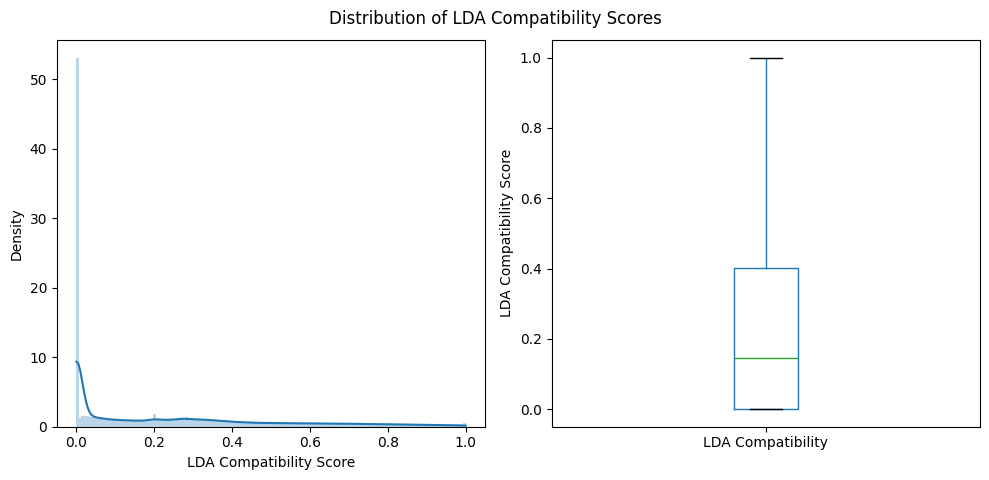

In [192]:
# LDA score distribution
plt.figure(figsize=(10, 5))  # Overall figure size

# First subplot for the histogram and KDE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(compatible_pairs_df['LDA_compatibility_score'], kde=True, stat="density", linewidth=0, alpha=0.3)
plt.xlabel('LDA Compatibility Score')
plt.ylabel('Density')

# Second subplot for the boxplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
compatible_pairs_df[['LDA_compatibility_score']].boxplot()
plt.ylabel('LDA Compatibility Score')
plt.xticks([1], ['LDA Compatibility'])  # Adjust x-ticks for better readability
plt.grid(False)  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Distribution of LDA Compatibility Scores')
plt.show()


#### Keywords LDA compatibility score

In [120]:
# Get the topic distribution of each profile's keywords
keywords_topic_distributions = [optimal_keywords_LdaModel.get_document_topics(bow) for bow in keywords_bow]

# Compute profile similarity using cosine similarity

keywords_num_topics = optimal_keywords_LdaModel.num_topics

dense_keywords_topic_distributions = np.zeros((len(keywords_topic_distributions), keywords_num_topics))

for i, profile in enumerate(keywords_topic_distributions):
    for topic_id, prob in profile:
        dense_keywords_topic_distributions[i, topic_id] = prob

LDA_keywords_similarity_matrix = cosine_similarity(dense_keywords_topic_distributions)

# similarity_matrix is a 3000 x 3000 matrix

# Apply the get similarity score function to each row in compatible_pairs_df to create a new 'LDA_compatibility_score' column
compatible_pairs_df['LDA_keywords_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, LDA_keywords_similarity_matrix),
    axis=1
)

compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score
0,26866,21490,0.000000,0.000000
1,26866,2842,0.000000,0.000000
2,26866,6019,0.000000,0.000000
3,26866,47211,0.869895,0.000000
4,26866,11877,0.000000,0.000000
...,...,...,...,...
1991977,27776,52297,0.552030,0.000000
1991978,27776,7544,0.000000,0.000000
1991979,29238,52297,0.550999,0.000000
1991980,29238,7544,0.000000,0.000000


#### 2.2.a TF-IDF ####

Step1: Preprocessing (done)

Step 2: Generating TF-IDF Vectors: Convert the text of each profile into a vector using TF-IDF. This step involves calculating the TF (Term Frequency) and IDF (Inverse Document Frequency) for each word in the profiles, then producing a TF-IDF score for each word. Each profile is represented as a vector, where each dimension corresponds to a unique word in the corpus (set of all profiles considered), and the value is the TF-IDF score.

Step 3: Calculating Similarity

In [121]:
# Joining each lemmatized document from a list to a string representation becasue tf-IDF vectorizer
sample_lems = [" ".join(doc) for doc in sample.lems]

sample_lems[0:5]

['nice energetic happy lucky guy laugh lot like optimistic fun people ambitious drive enjoy socialize movie music eating travel random guy time currently time student time critical care currently work critical care nurse icu go school time currently work obtain doctorate nursing practice dnp process nurse practitioner find love deal school cool people smile give advice honest tell people need hear people intense think open honest good way make intense tooth high check bone particular favorite book vary like certain book different reason movie dirty dancing pretty woman underworld series way little mermaid pride prejudice food iphone ipod macbook pro good include friend family people care great love eat school like learnmy future vacation weekend getaway friend city food wine career future career new place check car end rest life man good hand turn love good handy haha head home lounging watch movie school work study maybe hang friend hopefully hate gym actually seek date social circuit

In [236]:
# Step 2: Generate TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_lems)

tfidf_matrix

<3000x32371 sparse matrix of type '<class 'numpy.float64'>'
	with 403788 stored elements in Compressed Sparse Row format>

In [199]:
print(tfidf_matrix[:1000, :1000].todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [237]:
# Step 3: Compute cosine similarity
tfidf_similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [238]:
# Match the tfidf similarity matrix to compatible_pairs_df to create a new 'tfidf_compatibility_score' column
compatible_pairs_df['tfidf_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, tfidf_similarity_matrix),
    axis=1
)

compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score,Composite_Score_LDA,Composite_Score_TF,Composite_Score_W2V,Composite_Score_Glo
0,26866,21490,0.386787,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000,0.492903,0.500107,0.810935,0.853664
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737,0.231392,0.234373,0.515942,0.588485
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737,0.218768,0.222766,0.524694,0.551579
3,26866,47211,0.867784,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000,0.913842,0.489896,0.838337,0.839821
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000,0.478894,0.482824,0.782345,0.817036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552869,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959,0.758487,0.489997,0.928487,0.915400
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000,0.353894,0.357381,0.749134,0.770158
1991979,29238,52297,0.551835,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959,0.757972,0.496313,0.937054,0.932245
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000,0.353894,0.361827,0.750237,0.783612


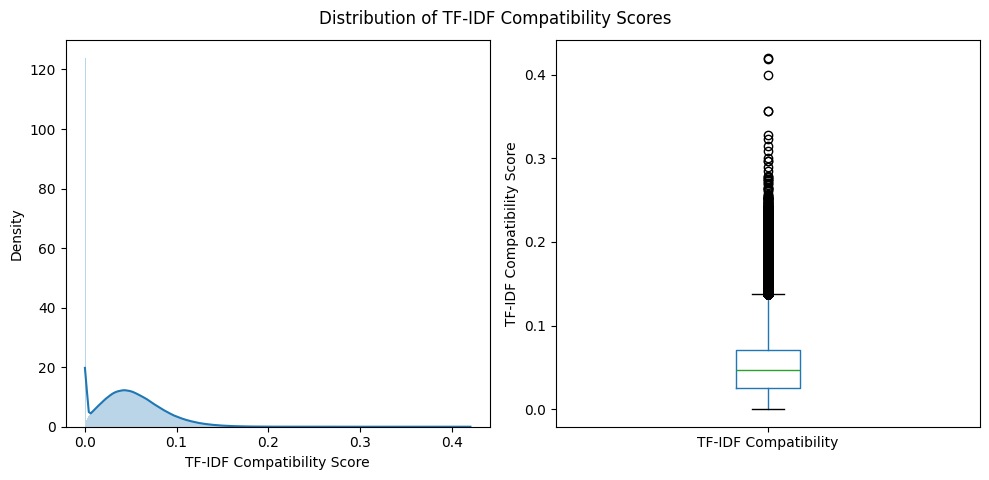

In [193]:
# TF-IDF score distribution
plt.figure(figsize=(10, 5))  # Overall figure size

# First subplot for the histogram and KDE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
sns.histplot(compatible_pairs_df['tfidf_compatibility_score'], kde=True, stat="density", linewidth=0, alpha=0.3)
plt.xlabel('TF-IDF Compatibility Score')
plt.ylabel('Density')

# Second subplot for the boxplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
compatible_pairs_df[['tfidf_compatibility_score']].boxplot()
plt.ylabel('TF-IDF Compatibility Score')
plt.xticks([1], ['TF-IDF Compatibility']) 
plt.grid(False)  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Distribution of TF-IDF Compatibility Scores')
plt.show()

#### TF-IDF with keywords

In [131]:
# Generate Tf-IDF matrix
tfidf_keywords_matrix = tfidf_vectorizer.fit_transform(keywords_str)

# Compute cosine similarity
tfidf_keywords_similarity_matrix = cosine_similarity(tfidf_keywords_matrix, tfidf_keywords_matrix)

# Match the tfidf similarity matrix to compatible_pairs_df to create a new 'tfidf_compatibility_score' column
compatible_pairs_df['tfidf_keywords_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, tfidf_keywords_similarity_matrix),
    axis=1
)

compatible_pairs_df


,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score
0,26866,21490,0.000000,0.000000,0.014408,0.0
1,26866,2842,0.000000,0.000000,0.005961,0.0
2,26866,6019,0.000000,0.000000,0.007996,0.0
3,26866,47211,0.869895,0.000000,0.022003,0.0
4,26866,11877,0.000000,0.000000,0.007858,0.0
...,...,...,...,...,...,...
1991977,27776,52297,0.552030,0.000000,0.015048,0.0
1991978,27776,7544,0.000000,0.000000,0.006973,0.0
1991979,29238,52297,0.550999,0.000000,0.027681,0.0
1991980,29238,7544,0.000000,0.000000,0.015865,0.0


In [175]:
# Visually inspect the highest score pairs

# Find the highest scores and corresponding user IDs
highest_scores_rows = [
    compatible_pairs_df.loc[compatible_pairs_df['LDA_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['LDA_keywords_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['tfidf_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['tfidf_keywords_compatibility_score'].idxmax()]
]

score_labels = [
    'LDA_compatibility_score',
    'LDA_keywords_compatibility_score',
    'tfidf_compatibility_score',
    'tfidf_keywords_compatibility_score'
]

# Function to search for text in 'sample' given an ID
def find_text_by_id(search_id):
    text_row = sample[sample['id'] == search_id]
    if not text_row.empty:
        return text_row['texts'].values[0]
    return None

# Retrieve texts for both user1_id and user2_id if they exist in 'sample'
texts_info = []
for label in score_labels:
    highest_score_row = compatible_pairs_df.loc[compatible_pairs_df[label].idxmax()]
    user1_text = find_text_by_id(highest_score_row['user1_id'])
    user2_text = find_text_by_id(highest_score_row['user2_id'])
    
    texts_info.append({
        'score_label': label,
        'user1_id': highest_score_row['user1_id'],
        'user1_text': user1_text,
        'user2_id': highest_score_row['user2_id'],
        'user2_text': user2_text
    })

# Displaying the results
for info in texts_info:
    print(f"Score Type: {info['score_label']}")
    print(f"User1 ID: {info['user1_id']}, User1 Text: {info['user1_text']}")
    print(f"User2 ID: {info['user2_id']}, User2 Text: {info['user2_text']}\n")


Score Type: LDA_compatibility_score
User1 ID: 34596.0, User1 Text: ..........
User2 ID: 59395.0, User2 Text: ..........

Score Type: LDA_keywords_compatibility_score
User1 ID: 34596.0, User1 Text: ..........
User2 ID: 15162.0, User2 Text: i'm a freelance graphic designer and yoga instructor. i travel around the world to teach workshops. i'm also also passionate about massage, cooking, and spending time with people i care about.how to reverse global warming and how to accomplish everything i want to do in a daykissingmy eyesthai food, lonely planet guides, on the road, kurt vonneugt.....chocolate yoga friends baths books i padtravel.....making dinner for my friendsi'm pretty private....ask me when you know me betteryou want to get to know me....

Score Type: tfidf_compatibility_score
User1 ID: 30550.0, User1 Text: if you want to get to know me than ask me a question, oh yes if you ask why i'm on here because i am married.. don't bother contacting me. good day to you!  i really enjoy get

The results from keyword analysis are unstable. As we can see from above, the generated keyword topics associated with the highest coherence scores demonstrate considerable overlap, and the model frequently produced topics comprised of words lacking substantial meaning (each assigned a weight of 0.000). This issue may stem from either the sparsity of the keywords data or an excessively high topic count (95) given the size of the dataset (3,000 rows). Paradoxically, coherence scores appeared to improve with an increase in the number of topics, a trend that seems counterintuitive. Consequently, I have decided to focus on the LDA_compatibility_score and the tfidf_compatibility_score derived from the complete lemmatized texts for the time being.

#### Question: Why did LDA compatibility and TF-IDF give such different results? ####

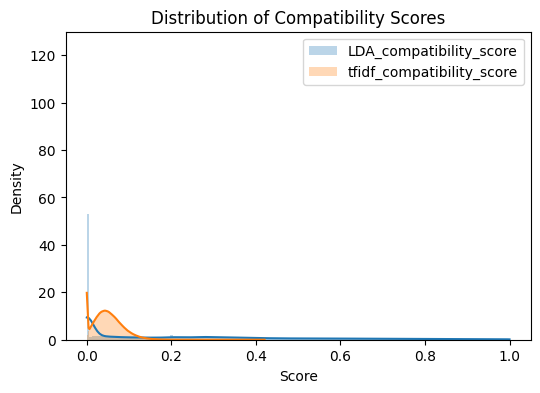

In [144]:
# Visualize the two distributions
plt.figure(figsize=(6, 4))

# Plotting each column as a histogram and line plot
for column in ['LDA_compatibility_score', 
               'tfidf_compatibility_score']:
    sns.histplot(compatible_pairs_df[column], kde=True, stat="density", linewidth=0, alpha=0.3, label=column)

plt.title('Distribution of Compatibility Scores')
plt.xlabel('Score')
plt.ylabel('Density')
plt.legend()
plt.show()

LDA-based compatibility score has a much longer tail and a range of [0, 1], whereas TF-IDF-based compatibility score has a smaller range of [0, 0.42] and more density in the lower region.

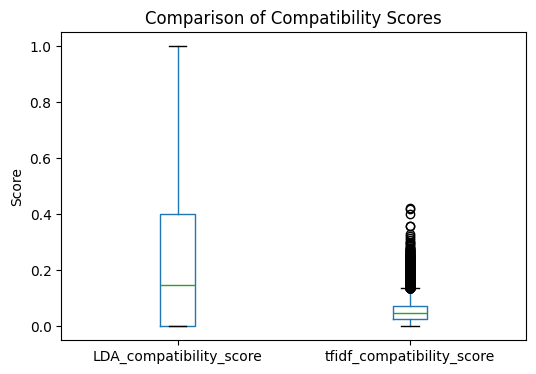

In [180]:
scores = compatible_pairs_df[['LDA_compatibility_score', 
             'tfidf_compatibility_score']]

# Plot
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
scores.boxplot()
plt.title('Comparison of Compatibility Scores')
plt.ylabel('Score')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(False)  # Optional: turn off the grid for aesthetics
plt.show()

#### 2.3 Embeddings ####

##### 2.3.a. Word2Vec

In [156]:
import gensim.downloader as api

model_path = api.load("word2vec-google-news-300", return_path=True)


In [239]:
from gensim.models import KeyedVectors

# Load the model
Word2Vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Function to vectorize a document based on the mean of its word vectors
def vectorize_document(document_tokens, model):
    word_vectors = [model[word] for word in document_tokens if word in model.key_to_index]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Compute the average embedding vector of each document by averaging across words in a document
    else:
        return np.zeros(model.vector_size) 

# Vectorize all documents
document_vectors = np.array([vectorize_document(doc, Word2Vec_model) for doc in sample.lems])

In [240]:
# Compute the cosine similarity matrix
Word2Vec_similarity_matrix = cosine_similarity(document_vectors)

# Word2Vec_similarity_matrix is now a 3000x3000 matrix where each element [i, j]
# represents the cosine similarity between document i and document j

# Match the Word2Vecsimilarity matrix to compatible_pairs_df to create a new 'Word2Vec_compatibility_score' column
compatible_pairs_df['Word2Vec_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, Word2Vec_similarity_matrix),
    axis=1
)
compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score,Composite_Score_LDA,Composite_Score_TF,Composite_Score_W2V,Composite_Score_Glo
0,26866,21490,0.386787,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000,0.492903,0.500107,0.810935,0.853664
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737,0.231392,0.234373,0.515942,0.588485
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737,0.218768,0.222766,0.524694,0.551579
3,26866,47211,0.867784,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000,0.913842,0.489896,0.838337,0.839821
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000,0.478894,0.482824,0.782345,0.817036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552869,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959,0.758487,0.489997,0.928487,0.915400
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000,0.353894,0.357381,0.749134,0.770158
1991979,29238,52297,0.551835,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959,0.757972,0.496313,0.937054,0.932245
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000,0.353894,0.361827,0.750237,0.783612


#### 2.3.b. GloVe

In [201]:
from gensim.scripts.glove2word2vec import glove2word2vec

glove_input_file = '/Users/hanqingye/Documents/glove/glove.6B.300d.txt'  # Update
# Output file name for the Word2Vec format
word2vec_output_file = 'glove.6B.300d.word2vec.txt'

# Convert the GloVe file to Word2Vec format
glove2word2vec(glove_input_file, word2vec_output_file)


/var/folders/90/m_21jg5n2yj6pwrhmkdvtm1h0000gn/T/ipykernel_37516/1761549416.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400001, 300)

In [241]:
# Load the converted GloVe model
GloVe_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Assuming sample.lems contains your tokenized documents
GloVe_document_vectors = np.array([vectorize_document(doc, GloVe_model) for doc in sample.lems])


# GloVe_similarity_matrix is now a 3000x3000 matrix where each element [i, j]
# represents the cosine similarity between document i and document j


In [242]:
# Compute the cosine similarity matrix
GloVe_similarity_matrix = cosine_similarity(GloVe_document_vectors)

# Match the Word2Vecsimilarity matrix to compatible_pairs_df to create a new 'Word2Vec_compatibility_score' column
compatible_pairs_df['GloVe_compatibility_score'] = compatible_pairs_df.apply(
    lambda row: get_similarity_score(row['user1_id'], row['user2_id'], id_to_index, GloVe_similarity_matrix),
    axis=1
)
compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score,Composite_Score_LDA,Composite_Score_TF,Composite_Score_W2V,Composite_Score_Glo
0,26866,21490,0.386787,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000,0.492903,0.500107,0.810935,0.853664
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737,0.231392,0.234373,0.515942,0.588485
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737,0.218768,0.222766,0.524694,0.551579
3,26866,47211,0.867784,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000,0.913842,0.489896,0.838337,0.839821
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000,0.478894,0.482824,0.782345,0.817036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552869,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959,0.758487,0.489997,0.928487,0.915400
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000,0.353894,0.357381,0.749134,0.770158
1991979,29238,52297,0.551835,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959,0.757972,0.496313,0.937054,0.932245
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000,0.353894,0.361827,0.750237,0.783612


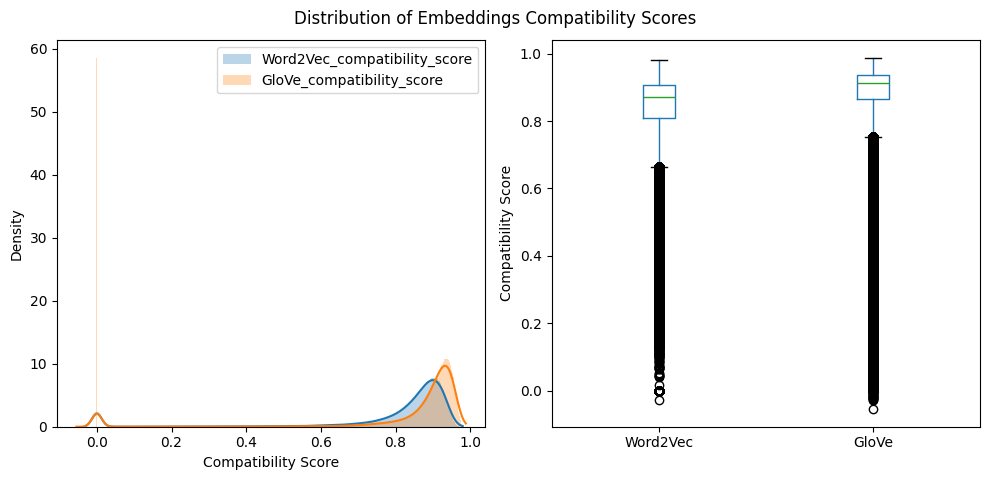

In [213]:
plt.figure(figsize=(10, 5))  # Overall figure size

# First subplot for the histogram and KDE
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
for column in ['Word2Vec_compatibility_score', 'GloVe_compatibility_score']:
    sns.histplot(compatible_pairs_df[column], kde=True, stat="density", linewidth=0, alpha=0.3, label=column)
plt.xlabel('Compatibility Score')
plt.ylabel('Density')
plt.legend()

# Second subplot for the boxplot - Adjusted for proper handling
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
# Using pandas' boxplot for multiple columns directly rather than in a loop
compatible_pairs_df[['Word2Vec_compatibility_score', 'GloVe_compatibility_score']].boxplot()
plt.ylabel('Compatibility Score')
plt.xticks(ticks=[1, 2], labels=['Word2Vec', 'GloVe']) 
plt.grid(False)  

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Distribution of Embeddings Compatibility Scores')
plt.show()

In [179]:
# Visually inspect the highest score pairs

# Find the highest scores and corresponding user IDs
highest_scores_rows = [
    compatible_pairs_df.loc[compatible_pairs_df['LDA_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['tfidf_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['Word2Vec_compatibility_score'].idxmax()],
    compatible_pairs_df.loc[compatible_pairs_df['GloVe_compatibility_score'].idxmax()]
]

score_labels = [
    'LDA_compatibility_score',
    'tfidf_compatibility_score',
    'Word2Vec_compatibility_score',
    'GloVe_compatibility_score'
]

# Retrieve texts for both user1_id and user2_id if they exist in 'sample'
texts_info = []
for label in score_labels:
    highest_score_row = compatible_pairs_df.loc[compatible_pairs_df[label].idxmax()]
    score = highest_score_row[label] 
    user1_text = find_text_by_id(highest_score_row['user1_id'])
    user2_text = find_text_by_id(highest_score_row['user2_id'])
    
    texts_info.append({
        'score': score,
        'score_label': label,
        'user1_id': highest_score_row['user1_id'],
        'user1_text': user1_text,
        'user2_id': highest_score_row['user2_id'],
        'user2_text': user2_text
    })

# Displaying the results
for info in texts_info:
    print(f"Score Type: {info['score_label']}")
    print(f"Score: {info['score']}")
    print(f"User1 ID: {info['user1_id']}, User1 Text: {info['user1_text']}")
    print(f"User2 ID: {info['user2_id']}, User2 Text: {info['user2_text']}\n")

Score Type: LDA_compatibility_score
Score: 1.0000000000000007
User1 ID: 34596.0, User1 Text: ..........
User2 ID: 59395.0, User2 Text: ..........

Score Type: tfidf_compatibility_score
Score: 0.4205003645470413
User1 ID: 30550.0, User1 Text: if you want to get to know me than ask me a question, oh yes if you ask why i'm on here because i am married.. don't bother contacting me. good day to you!  i really enjoy getting to know new people.you can find that out if you askguess you'll never know unless you ask right?my sparkling personality :), my eyesguess you'll never know unless you ask right?guess you'll never know unless you ask right?guess you'll never know unless you ask right?guess you'll never know unless you ask right?guess you'll never know unless you ask right?.
User2 ID: 17627.0, User2 Text: long story ask if u wanna know :).........

Score Type: Word2Vec_compatibility_score
Score: 0.9798527549357329
User1 ID: 53022.0, User1 Text: the journey of a thousand miles begins with a 

#### 3. Attributes matching (age, education) ####

In [215]:
# The maximum age difference in our sample profiles 
max_age_diff = sample['age'].max() - sample['age'].min()
max_age_diff

50

In [216]:
# Age compatibility function

import scipy.stats as stats

def age_compatibility(user1_age, user2_age, max_age_diff=max_age_diff):
    age_diff = abs(user1_age - user2_age)
    # Scale the distribution so that a difference of max_age_diff results in a score of 0
    scale = max_age_diff / 3  # 3 standard deviations from the mean covers 99.7% of the distribution
    score = stats.norm.pdf(age_diff, loc=0, scale=scale) # loc = mean and scale = sd
    score_scaled = score / stats.norm.pdf(0, loc=0, scale=scale)  # Scale so that maximum score is 1
    return score_scaled

In [217]:
id_to_age = sample.set_index('id')['age'].to_dict()

def compute_pair_age_compatibility_and_ages(row):
    user1_age = id_to_age[row['user1_id']]
    user2_age = id_to_age[row['user2_id']]
    compatibility_score = age_compatibility(user1_age, user2_age, max_age_diff)
    return user1_age, user2_age, compatibility_score

# Apply the modified function and split the results into multiple new columns
compatible_pairs_df[['user1_age', 'user2_age', 'age_compatibility_score']] = compatible_pairs_df.apply(
    lambda row: compute_pair_age_compatibility_and_ages(row),
    axis=1, result_type='expand'
)

In [ ]:
# Alternative age compatibility function
#import scipy.stats as stats

#def new_age_compatibility(user1_age, user2_age, max_age_diff):
#   age_diff = abs(user1_age - user2_age)
#    
    # Ensure compatibility is 1 when age_diff is 0
#    if age_diff == 0:
#        return 1.0
#    # Linearly decrease score based on age_diff
#    score = max(0, (1 - age_diff / max_age_diff))
    
#    return score

#def compute_pair_age_compatibility_and_ages(row):
#    user1_age = id_to_age[row['user1_id']]
#    user2_age = id_to_age[row['user2_id']]
#    compatibility_score = new_age_compatibility(user1_age, user2_age, max_age_diff)
#    return user1_age, user2_age, compatibility_score

#compatible_pairs_df[['user1_age', 'user2_age', 'age_compatibility_score_linear_scale']] = compatible_pairs_df.apply(
#    lambda row: compute_pair_age_compatibility_and_ages(row),
#    axis=1, result_type='expand'
#)

In [218]:
# Create a dictionary to map from user ID to age
id_to_age = sample.set_index('id')['age'].to_dict()

# Function to get ages for a pair and compute compatibility score
def compute_pair_age_compatibility(row):
    user1_age = id_to_age[row['user1_id']]
    user2_age = id_to_age[row['user2_id']]
    return age_compatibility(user1_age, user2_age, max_age_diff)

# Apply the function across all rows in compatible_pairs_df
compatible_pairs_df['age_compatibility_score'] = compatible_pairs_df.apply(compute_pair_age_compatibility, axis=1)

In [221]:
# Education compatibility function

max_edu_diff = sample['education_level'].max() - 2 #2 is the minimum education not taking into account "other" type of education

def edu_compatibility(user1_edu, user2_edu, max_edu_diff=max_edu_diff):
    # Check if either education level is '1', indicating "other"
    if (user1_edu == 1) or (user2_edu == 1):
        return 0.5
    
    # Calculate the absolute difference in education levels
    edu_diff = abs(user1_edu - user2_edu)
    
    # If the difference is 0, return maximum compatibility
    if edu_diff == 0:
        return 1
    # If the difference is greater than or equal to the max difference, return minimum compatibility
    elif edu_diff >= max_edu_diff:
        return 0
    else:
        # For differences in between, calculate a scaled score based on a normal distribution
        scale = max_edu_diff / 3  # Standard deviation to cover the range of differences
        score = stats.norm.pdf(edu_diff, loc=0, scale=scale)  # Normal distribution PDF value for the difference
        score_scaled = score / stats.norm.pdf(0, loc=0, scale=scale)  # Scale so maximum score is 1
        return score_scaled

In [222]:
# Create a dictionary to map from user ID to education
id_to_edu = sample.set_index('id')['education_level'].to_dict()

# Function to get ages for a pair and compute compatibility score
def compute_pair_edu_compatibility(row):
    user1_edu = id_to_edu[row['user1_id']]
    user2_edu = id_to_edu[row['user2_id']]
    return edu_compatibility(user1_edu, user2_edu, max_edu_diff)

# Apply the function across all rows in compatible_pairs_df
compatible_pairs_df['edu_compatibility_score'] = compatible_pairs_df.apply(compute_pair_edu_compatibility, axis=1)

#### 4. Calculate composite score ####

In [223]:
compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score
0,26866,21490,0.000000,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737
3,26866,47211,0.869895,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552030,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000
1991979,29238,52297,0.550999,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000


In [224]:
# Generate composite scores with simple weighting
compatible_pairs_df["Composite_Score_LDA"] = 0.25 * compatible_pairs_df["age_compatibility_score"] + \
                                 0.25 * compatible_pairs_df["edu_compatibility_score"] + \
                                 0.5 * compatible_pairs_df["LDA_compatibility_score"]

compatible_pairs_df["Composite_Score_TF"] = 0.25 * compatible_pairs_df["age_compatibility_score"] + \
                                 0.25 * compatible_pairs_df["edu_compatibility_score"] + \
                                 0.5 * compatible_pairs_df["tfidf_compatibility_score"]

compatible_pairs_df["Composite_Score_W2V"] = 0.25 * compatible_pairs_df["age_compatibility_score"] + \
                                 0.25 * compatible_pairs_df["edu_compatibility_score"] + \
                                 0.5 * compatible_pairs_df["Word2Vec_compatibility_score"]

compatible_pairs_df["Composite_Score_Glo"] = 0.25 * compatible_pairs_df["age_compatibility_score"] + \
                                 0.25 * compatible_pairs_df["edu_compatibility_score"] + \
                                 0.5 * compatible_pairs_df["GloVe_compatibility_score"]

In [231]:
compatible_pairs_df

,user1_id,user2_id,LDA_compatibility_score,LDA_keywords_compatibility_score,tfidf_compatibility_score,tfidf_keywords_compatibility_score,Word2Vec_compatibility_score,GloVe_compatibility_score,user1_age,user2_age,age_compatibility_score,edu_compatibility_score,Composite_Score_LDA,Composite_Score_TF,Composite_Score_W2V,Composite_Score_Glo
0,26866,21490,0.000000,0.000000,0.014408,0.0,0.636065,0.721522,27.0,31.0,0.971611,1.000000,0.492903,0.500107,0.810935,0.853664
1,26866,2842,0.000000,0.000000,0.005961,0.0,0.569100,0.714185,27.0,61.0,0.124830,0.800737,0.231392,0.234373,0.515942,0.588485
2,26866,6019,0.000000,0.000000,0.007996,0.0,0.611852,0.665623,27.0,65.0,0.074333,0.800737,0.218768,0.222766,0.524694,0.551579
3,26866,47211,0.869895,0.000000,0.022003,0.0,0.718886,0.721853,27.0,34.0,0.915578,1.000000,0.913842,0.489896,0.838337,0.839821
4,26866,11877,0.000000,0.000000,0.007858,0.0,0.606902,0.676283,27.0,34.0,0.915578,1.000000,0.478894,0.482824,0.782345,0.817036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991977,27776,52297,0.552030,0.000000,0.015048,0.0,0.892028,0.865854,25.0,28.0,0.983931,0.945959,0.758487,0.489997,0.928487,0.915400
1991978,27776,7544,0.000000,0.000000,0.006973,0.0,0.790479,0.832527,25.0,18.0,0.915578,0.500000,0.353894,0.357381,0.749134,0.770158
1991979,29238,52297,0.550999,0.000000,0.027681,0.0,0.909163,0.899544,25.0,28.0,0.983931,0.945959,0.757972,0.496313,0.937054,0.932245
1991980,29238,7544,0.000000,0.000000,0.015865,0.0,0.792685,0.859435,25.0,18.0,0.915578,0.500000,0.353894,0.361827,0.750237,0.783612


#### 5. Rank and Select

In [230]:
len(compatible_pairs_df.user2_id.unique())

1949

In [70]:
# Find Top-5 matches for each profile
N = 5  # Number of top matches to find for each profile

# Exclude self-similarity by setting diagonal to -1
np.fill_diagonal(similarity_matrix, -1)

top_n_matches = {}

for i, row in enumerate(similarity_matrix):
    # Get indices of the top N values in each row (i.e., for each profile)
    top_indices = row.argsort()[-N:][::-1]
    top_n_matches[i] = top_indices

# `top_n_matches` is a dictionary where each key is a profile index (0:2999) and the value is a list of indices for its top N matches (0:2999)
# to get the actual indices, we need to index "sample"
top_n_matches_ids = {}

for index, matches in top_n_matches.items():
    # The profile's ID is its index within the `sample`
    profile_id = sample.index[index]
    
    # Retrieve the IDs for the top N matches using their indices
    match_ids = [sample.index[match_index] for match_index in matches]
    
    # Map the profile ID to its match IDs
    top_n_matches_ids[profile_id] = match_ids


In [74]:
# Visually inspect the matches for a random user

profile_id_to_inspect = list(top_n_matches_ids.keys())[0]

matching_ids = top_n_matches_ids[profile_id_to_inspect]

# Print the text data for the selected profile
print("Selected Profile ID:", profile_id_to_inspect)
print("Text:", sample.loc[profile_id_to_inspect, 'texts'])
print("\n--- Top N Matches ---\n")

# Iterate over the matching IDs and print their text data
for match_id in matching_ids:
    print("Match Profile ID:", match_id)
    print("Text:", sample.loc[match_id, 'texts'])
    print("\n")



Selected Profile ID: 45171
Text: i might be the girl your mother warned you about.lying in bed listening to music. writing things that aren't online dating profiles. trying to figure out the best definition for "meme" so i can tell my friends who are not internet addicx why impact is the font that defines our generation. incessantly approximating employment.sleeping more than 8 hours. competitive thrift shopping. shaking off hangovers. wandering aimlessly. stylistically avoiding capitalization.t&apunk shows, dance parties, hip hop shows, noise shows, underground rock'n'roll parties, 30 rock marathons, naps in the park, x-files  most recent favorite movies: in the realm of the senses, dark passage, who are you polly magoo, downtown 81, ciao manhattan, sweet movie, wave twisters, dr. caligari, peewee herman's big adventure, con air, beyond the valley of the dolls, mildred pierce, rain, 5000 fingers of dr t, the adventures of baron von munchausen, helvetica, satyricon, labyrinth, l'avvent